In [ ]:
import numpy as np 
import pandas as pd 
import os, time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os
from keras.datasets import fashion_mnist

In [ ]:
#train_data.head()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)
print(X_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
classes = np.unique(y_train)
num_classes = len(classes)
num_classes

10

The images of fashionMNIST are black and white, while the required input for VGG19 must be colored images. Thus, I convert the images into colored ones with 3 channels R, G, B.

In [ ]:
train_X=np.dstack([X_train] * 3)
test_X=np.dstack([X_test]*3)
train_X.shape,test_X.shape

((60000, 28, 84), (10000, 28, 84))

In [ ]:
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [ ]:
from tensorflow.keras.utils import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in test_X])
#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

Converting Labels to one hot encoded format

In [ ]:
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)

In [ ]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )


In [ ]:
# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 32, 32, 3), (12000, 32, 32, 3), (48000, 10), (12000, 10))

Defining the parameters for instanitaing VGG16 model.

In [ ]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_DEPTH = 3
BATCH_SIZE = 16

In [ ]:
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [ ]:
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)

750/750 [==============================] - 4s 5ms/step


In [ ]:
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, valid_label)

In [ ]:
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [ ]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [ ]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers import LeakyReLU

In [ ]:
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])


Reduced learning and Early stopping for callback Implementation

In [ ]:
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]


In [ ]:
# Train the Model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Epoch 1/100
1500/1500 [==============================] - 5s 3ms/step - loss: 2.4509 - acc: 0.0996 - val_loss: 2.3528 - val_acc: 0.1049 - lr: 0.0010
Epoch 2/100
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3400 - acc: 0.1001 - val_loss: 2.3142 - val_acc: 0.0983 - lr: 0.0010
Epoch 3/100
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3042 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.0992 - lr: 0.0010
Epoch 4/100
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3028 - acc: 0.0989 - val_loss: 2.3027 - val_acc: 0.1007 - lr: 0.0010
Epoch 5/100
1497/1500 [============================>.] - ETA: 0s - loss: 2.3028 - acc: 0.0993
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3028 - acc: 0.0994 - val_loss: 2.3028 - val_acc: 0.0993 - lr: 0.0010
Epoch 6/100
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3026 - acc: 0.1002 - v

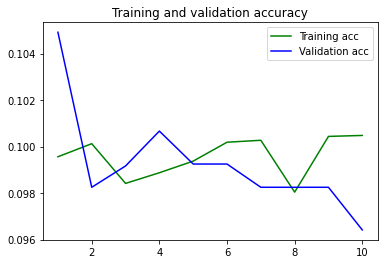

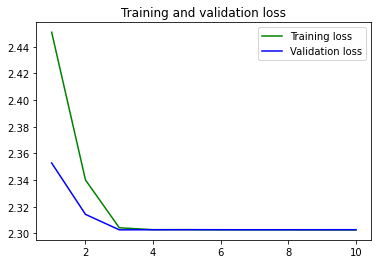

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 267,786
Trainable params: 267,786
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Here X_test, y_test are the test data points
predictions = model.predict(val_features_flat)
predictions

375/375 [==============================] - 1s 3ms/step


array([[0.10074601, 0.09966848, 0.10072567, ..., 0.09942259, 0.09975533,
        0.09884603],
       [0.10074601, 0.09966848, 0.10072567, ..., 0.09942259, 0.09975533,
        0.09884603],
       [0.10074601, 0.09966848, 0.10072567, ..., 0.09942259, 0.09975533,
        0.09884603],
       ...,
       [0.10074601, 0.09966848, 0.10072567, ..., 0.09942259, 0.09975533,
        0.09884603],
       [0.10074601, 0.09966848, 0.10072567, ..., 0.09942259, 0.09975533,
        0.09884603],
       [0.10074601, 0.09966848, 0.10072567, ..., 0.09942259, 0.09975533,
        0.09884603]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred=model.predict(val_features_flat) 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(valid_label, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

375/375 [==============================] - 1s 1ms/step
[[1157    0    0    0    0    0    0    0    0    0]
 [1219    0    0    0    0    0    0    0    0    0]
 [1179    0    0    0    0    0    0    0    0    0]
 [1188    0    0    0    0    0    0    0    0    0]
 [1191    0    0    0    0    0    0    0    0    0]
 [1190    0    0    0    0    0    0    0    0    0]
 [1176    0    0    0    0    0    0    0    0    0]
 [1233    0    0    0    0    0    0    0    0    0]
 [1208    0    0    0    0    0    0    0    0    0]
 [1259    0    0    0    0    0    0    0    0    0]]


In [ ]:
# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(y_test, y_pred)}")

Accuracy of the classifier is: 0.09641666666666666


In [ ]:
# importing all necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

# confusion_matrix funnction a matrix containing the summary of predictions
print(confusion_matrix(y_test, y_pred))

# plot_confusion_matrix function is used to visualize the confusion matrix
# plot_confusion_matrix(model, val_features_flat, valid_label)
# plt.show()

[[1157    0    0    0    0    0    0    0    0    0]
 [1219    0    0    0    0    0    0    0    0    0]
 [1179    0    0    0    0    0    0    0    0    0]
 [1188    0    0    0    0    0    0    0    0    0]
 [1191    0    0    0    0    0    0    0    0    0]
 [1190    0    0    0    0    0    0    0    0    0]
 [1176    0    0    0    0    0    0    0    0    0]
 [1233    0    0    0    0    0    0    0    0    0]
 [1208    0    0    0    0    0    0    0    0    0]
 [1259    0    0    0    0    0    0    0    0    0]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.10      1.00      0.18      1157
           1       0.00      0.00      0.00      1219
           2       0.00      0.00      0.00      1179
           3       0.00      0.00      0.00      1188
           4       0.00      0.00      0.00      1191
           5       0.00      0.00      0.00      1190
           6       0.00      0.00      0.00      1176
           7       0.00      0.00      0.00      1233
           8       0.00      0.00      0.00      1208
           9       0.00      0.00      0.00      1259

    accuracy                           0.10     12000
   macro avg       0.01      0.10      0.02     12000
weighted avg       0.01      0.10      0.02     12000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
